# ch03.04_순환신경망 - Bidirectional-LSTM
---

* 날짜:
* 이름:


## 학습내용
    - 순환 신경망에 대해 이해한다.
    - BiLSTM
    - 로이터 뉴스기사 카테고리 분류
    - 스팀 리뷰 걈성 분류

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 로이터 뉴스 기사 분류
---

### | 데이터 전처리 

#### **데이터 불러오기**

In [97]:
MAX_FEATURES = 1000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=MAX_FEATURES)
print("훈련 데이터 : ", x_train.shape, y_train.shape)
print("테스트 데이터 : ", x_test.shape, y_test.shape)

훈련 데이터 :  (8982,) (8982,)
테스트 데이터 :  (2246,) (2246,)


C:\Users\user\miniconda3\envs\deep_tf\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\user\miniconda3\envs\deep_tf\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


#### **데이터 확인**

In [98]:
for k, v in word2index.items():
    if v <=10:
        print("k :",k,"\t","v :",v)

k : the 	 v : 4
k : in 	 v : 7
k : of 	 v : 5
k : to 	 v : 6
k : a 	 v : 10
k : said 	 v : 8
k : and 	 v : 9
k : <PAD> 	 v : 0
k : <START> 	 v : 1
k : <UNK> 	 v : 2
k : <UNUSED> 	 v : 3


In [99]:
print("첫번째 기사 :", x_train[0])
print("첫번째 기사의 카테고리 :", y_train[0])
print("카테고리 개수 :", np.max(y_train))

첫번째 기사 : [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
첫번째 기사의 카테고리 : 3
카테고리 개수 : 45


뉴스기사의 평균 길이 :  145.5398574927633


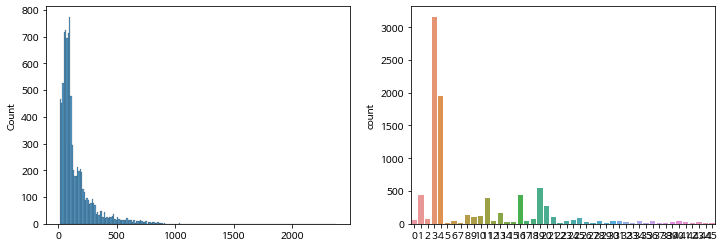

In [100]:
# 뉴스 기사의 평균 길이
plt.figure(figsize=(12,4))
len_sample = [len(x) for x in x_train]
plt.subplot(121); sns.histplot(x=len_sample)
plt.subplot(122); sns.countplot(x=y_train)
print("뉴스기사의 평균 길이 : ", np.mean(len_sample))

In [101]:
# 데이터 전처리 : 패딩
MAX_LEN = 128
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN, padding="post")
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_LEN, padding="post")
print("훈련 데이터 : ", x_train.shape, y_train.shape)
print("테스트 데이터 : ", x_test.shape, y_test.shape)

훈련 데이터 :  (8982, 128) (8982,)
테스트 데이터 :  (2246, 128) (2246,)


In [105]:
x_train_rev = x_train[:,::-1]
x_test_rev = x_test[:,::-1]

### | 임베딩 매트릭스 제작

```
! gdown https://drive.google.com/u/0/uc?id=1ams5_zp8NrfmbxSzTDCglRpAvjFGi5JY&export=download
! unzip  /content/glove.6B.zip
```


#### **단어-임베딩 딕셔너리**

```
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
```

In [77]:
embeddings_index = {}
f = open('D:Dataset/weights/glove.6B/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

#### **인덱싱-단어 딕셔너리**

In [52]:
word2index["<PAD>"] = 0
word2index["<START>"] = 1
word2index["<UNK>"] = 2  # unknown
word2index["<UNUSED>"] = 3

In [41]:
index2word = {}
for k, v in word2index.items():
    index2word[v]=k

In [85]:
print('imdb 딕셔너리의 모든 단어 수 :', len(word2index))
print('우리 모델에서 사용할 모든 단어 수 :', MAX_FEATURES)
print('glove 임베딩 에 있는 모든 단어 수 : ', len(embeddings_index))

imdb 딕셔너리의 모든 단어 수 : 30983
우리 모델에서 사용할 모든 단어 수 : 1000
glove 임베딩 에 있는 모든 단어 수 :  400000


#### **매트릭스 제작**

In [92]:
embed_mx = np.zeros((MAX_FEATURES, 100))
# 매트릭스의 크기 : (500, 100)
embed_mx.shape

for idx in range(4, 1004):
    word = index2word[idx]
    embed = embeddings_index.get(word)  # 딕셔너리.get 함수는 없으면 None값 반환
    #print(word, embed)
    if embed is not None:
        embed_mx[idx - 4] = embed
        
embed_mx

array([[-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.1529    , -0.24279   ,  0.89837003, ..., -0.59100002,
         1.00390005,  0.20664001],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ...,
       [ 0.29771999, -0.71969998,  0.74861002, ..., -0.15904   ,
         0.68975002,  0.28130999],
       [ 0.81173003,  0.39831999,  0.41034001, ...,  0.30888   ,
        -0.002799  , -0.15683   ],
       [ 0.19282   , -0.55668002,  0.27074999, ..., -0.075447  ,
         0.83173001, -0.48824   ]])

### | 모델학습 1

이때까지 배운 레이어를 사용하여 모델을 구축하세요.

```
Embedding()
RNN()
LSTM()
GRU()
GlobalAveragePooling1D()
Dense()
```

In [125]:
EMB_DIMS = 100
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=MAX_LEN))
model.add(tf.keras.layers.Embedding(MAX_FEATURES, EMB_DIMS))
model.add(tf.keras.layers.GRU(64,return_sequences=True))
model.add(tf.keras.layers.GRU(64,return_sequences=True))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(46,activation="softmax"))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 128, 100)          100000    
_________________________________________________________________
gru_9 (GRU)                  (None, 128, 64)           31872     
_________________________________________________________________
gru_10 (GRU)                 (None, 128, 64)           24960     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 46)                2990      
Total params: 159,822
Trainable params: 159,822
Non-trainable params: 0
_________________________________________________________________


In [126]:
model.layers[0].set_weights([embed_mx]) # 가중치를 Glove 값으로 초기화

In [127]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc'])

In [128]:
model.fit(x_train_rev, y_train,
          epochs=30,
          batch_size=128,validation_data=(x_test_rev,y_test))

Epoch 1/30
71/71 [==============================] - 5s 32ms/step - loss: 2.7704 - acc: 0.3080 - val_loss: 2.1574 - val_acc: 0.4252
Epoch 2/30
71/71 [==============================] - 2s 25ms/step - loss: 2.0948 - acc: 0.4312 - val_loss: 1.8930 - val_acc: 0.5111
Epoch 3/30
71/71 [==============================] - 2s 24ms/step - loss: 1.8094 - acc: 0.5329 - val_loss: 1.7444 - val_acc: 0.5708
Epoch 4/30
71/71 [==============================] - 2s 25ms/step - loss: 1.7000 - acc: 0.5748 - val_loss: 1.6660 - val_acc: 0.5917
Epoch 5/30
71/71 [==============================] - 2s 24ms/step - loss: 1.5848 - acc: 0.6048 - val_loss: 1.5851 - val_acc: 0.6229
Epoch 6/30
71/71 [==============================] - 2s 24ms/step - loss: 1.4620 - acc: 0.6358 - val_loss: 1.5327 - val_acc: 0.6238
Epoch 7/30
71/71 [==============================] - 2s 26ms/step - loss: 1.3777 - acc: 0.6572 - val_loss: 1.4590 - val_acc: 0.6420
Epoch 8/30
71/71 [==============================] - 2s 25ms/step - loss: 1.3144 - a

### | 모델학습 2

![](https://www.researchgate.net/profile/Arvind-Mohan-3/publication/324769532/figure/fig2/AS:619510805561344@1524714294669/LSTM-and-BiLSTM-Architectures.png)

In [130]:
EMB_DIMS = 100
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=MAX_LEN))
model.add(tf.keras.layers.Embedding(MAX_FEATURES, EMB_DIMS))

model.add(tf.keras.layers.Bidirectional( tf.keras.layers.GRU(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional( tf.keras.layers.GRU(64, return_sequences=True)))

model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(46,activation="softmax"))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 128, 100)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 128)          63744     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 128)          74496     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 46)                5934      
Total params: 244,174
Trainable params: 244,174
Non-trainable params: 0
_________________________________________________________________


In [131]:
model.layers[0].set_weights([embed_mx]) # 가중치를 Glove 값으로 초기화

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc'])

In [132]:
model.fit(x_train_rev, y_train,
          epochs=30,
          batch_size=128,validation_data=(x_test_rev,y_test))

Epoch 1/30
71/71 [==============================] - 8s 58ms/step - loss: 2.6761 - acc: 0.3345 - val_loss: 2.0233 - val_acc: 0.4947
Epoch 2/30
71/71 [==============================] - 3s 45ms/step - loss: 1.9080 - acc: 0.5248 - val_loss: 1.7020 - val_acc: 0.5855
Epoch 3/30
71/71 [==============================] - 3s 43ms/step - loss: 1.5780 - acc: 0.6149 - val_loss: 1.4913 - val_acc: 0.6362
Epoch 4/30
71/71 [==============================] - 3s 45ms/step - loss: 1.4085 - acc: 0.6476 - val_loss: 1.3677 - val_acc: 0.6714
Epoch 5/30
71/71 [==============================] - 3s 44ms/step - loss: 1.2286 - acc: 0.6948 - val_loss: 1.3142 - val_acc: 0.6728
Epoch 6/30
71/71 [==============================] - 3s 44ms/step - loss: 1.1516 - acc: 0.7167 - val_loss: 1.2419 - val_acc: 0.6870
Epoch 7/30
71/71 [==============================] - 3s 44ms/step - loss: 1.0477 - acc: 0.7375 - val_loss: 1.1909 - val_acc: 0.6999
Epoch 8/30
71/71 [==============================] - 3s 45ms/step - loss: 0.9485 - a

## 스팀 리뷰 감성 분류
---

https://wikidocs.net/94748

```
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
```